# Data Science Workshop
# NBA Free Throws Prediction

![title](img/free_throw_img.jpg)

In January 2015 a data-set of 600K NBA free-throws was upload to Kaggle by Sebastian-Mantey. The data was scraped from the website ESPN.com which belongs to an entertainment and sports programming network. 

Since the data-set was uploaded, 25 kernels were uploaded to Kaggle related to it. Most of the kernels summarize, analyze and visualize the data and do not try to predict anything. However, there are two interesting kernels:

The kernel ‘Shooting percentage over time’, engages with the questions How does the Free Throw shooting percent develop over time? Does it go down as the game approaches the ending due to higher pressure? Does it go up thanks to players being warmer, or alternatively - better shooters take the ball?

The findings of the analysis are that in the end of every quarter of a game, there is an increase in the number of free-throws and in the free-throws percentage. They also found that most of the throws in the end of every quarter were performed by better players, but still the absolute time of the throw affected the outcome more than how performed it. 

Another interesting kernel is ‘Pooling Partial Hierarchica via champs throw Free’, in which they try to find the best players in the data-set with statistical and probability methods such as complete pooling, and find the probability p for every player to succeed in the free-throw. 

Outside Kaggle, we found the article ‘Mindfulness and Free Throws’. This article investigate the relationship between mindfulness, preshot routine, and basketball free-throw percentage. The findings suggest that the combination of mindfulness levels, skill level (practice free-throw percentage), and competitive experience (year in school), all contribute to the prediction of competitive free throw percentage.


In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip -q install PandasBasketball
!{sys.executable} -m pip -q install shap
!{sys.executable} -m pip -q install xgboost
!{sys.executable} -m pip -q install sklearn
!{sys.executable} -m pip -q install matplotlib
!{sys.executable} -m pip -q install IPython
!{sys.executable} -m pip -q install imblearn
!{sys.executable} -m pip -q install bs4
!{sys.executable} -m pip -q install requests
!{sys.executable} -m pip -q install scipy

## Import Python Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
import shap
import json
import xgboost

from xgboost import XGBClassifier
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from preProcess import detect_and_remove_outliers,data_normalization
from keras.models import model_from_json
from keras import backend as K
from preProcess import preProcess_position,make_pos_column_as_one_hot
from our_models import logreg_grid_search,random_forest,logreg,knn_grid_search,plot_as_func_threshold
from our_models import neural_net_model, focal_loss_nn_model
from DataVisualization import plot_confusion,analyze_shots_per_game,find_correlations,plot_general_info
from DataVisualization import plot_score_percentage_per_position,plot_throws_statistics
from DataVisualization import plot_distributions,plot_distributions_of_shooting_percentage_only
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from IPython.display import Image,display
from imblearn.over_sampling import SMOTE



%matplotlib inline

Using TensorFlow backend.



## Loading The Original Dataset


In [3]:
free_throws_db = pd.read_csv('free_throws.csv')
free_throws_db.drop_duplicates()
free_throws_db.head(2)

,end_result,game,game_id,period,play,player,playoffs,score,season,shot_made,time
0,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 1 of 2,Andrew Bynum,regular,0 - 1,2006 - 2007,1,11:45
1,106 - 114,PHX - LAL,261031013,1,Andrew Bynum makes free throw 2 of 2,Andrew Bynum,regular,0 - 2,2006 - 2007,1,11:45


Describition of dataset:
- end_result: host total score - guest total score
- game: host team vs guest team
- game_id: id of specific game
- period: which quarter
- play: who make free throw, make or miss free throw
- player: player name
- playoffs: whether a playoff game or regular game
- score: host team score - guest team score at that time
- season: NBA season
- shot_made: whether player got the free throw
- time: time left in that quarter

## Data Preparation - build a complete dataset

#### step 1 - Analyzing the dataset
First thing, we wanted to understand our dataset nature and properties.
Here we attach some of the techniques we used to get some understanding on our data.

In the dataset we have 1097 players
In the dataset we have 10 seasons
**************************************
Total shots recorded: 618019
**************************************
Shots made are 0.76 % of dataset
Shots missed are 0.24 % of dataset
**************************************
missing data by category:
 end_result    0.0
game          0.0
game_id       0.0
period        0.0
play          0.0
player        0.0
playoffs      0.0
score         0.0
season        0.0
shot_made     0.0
time          0.0
dtype: float64
**************************************
shots attempted per game:
 playoffs     playoffs  regular
season                        
2006 - 2007      4116    63496
2007 - 2008      4384    61116
2008 - 2009      4455    60900
2009 - 2010      4447    60357
2010 - 2011      4185    59952
2011 - 2012      3972    44487
2012 - 2013      4078    54298
2013 - 2014      4389    57901
2014 - 2015      4049    56082
2015 - 2016      4051    57304
shots made per game:
 playoffs     pla

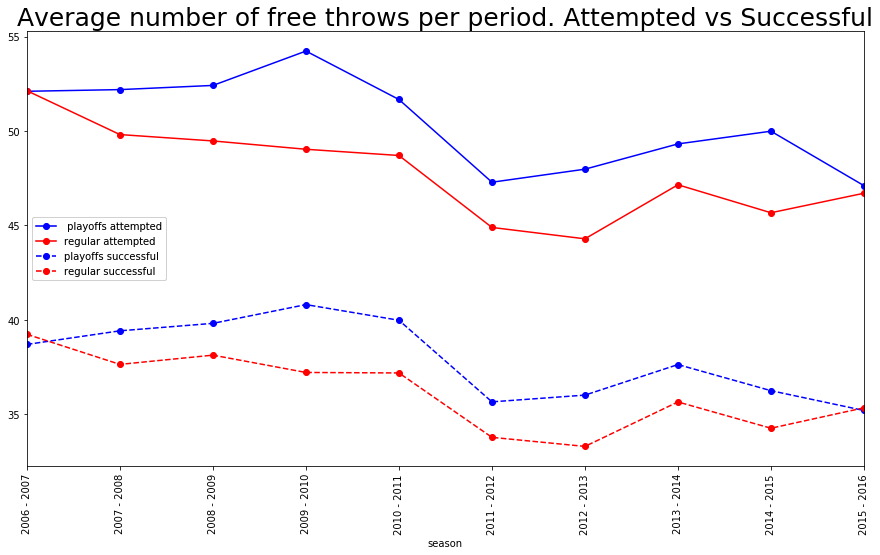

In [4]:
print("In the dataset we have",free_throws_db["player"].nunique() , "players")
("**************************************")
print("In the dataset we have",free_throws_db["season"].nunique() , "seasons")
print("**************************************")
counts = free_throws_db.shot_made.value_counts()
print("Total shots recorded:",counts[0]+counts[1])
print("**************************************")
print(f"Shots made are {counts[1]/free_throws_db.shape[0]:.2f} % of dataset")
print(f"Shots missed are {counts[0]/free_throws_db.shape[0]:.2f} % of dataset")
print("**************************************")
missing_data = free_throws_db.isnull().sum() * 100 / len(free_throws_db)
print("missing data by category:\n" , missing_data)
print("**************************************")
shot_attempted_per_game = free_throws_db.groupby(["season", "playoffs"])['shot_made'].count().unstack()
shot_made_per_game = free_throws_db.groupby(["season", "playoffs"])['shot_made'].sum().unstack()
print("shots attempted per game:\n", shot_attempted_per_game)
print("shots made per game:\n", shot_made_per_game)
analyze_shots_per_game(free_throws_db)

#### step 2 - Collecting more data from internet
In order to expand our primary dataset, we decided to use an open source python library PandasBasketball, and use a webscrapper in order to get more players stats from https://www.basketball-reference.com website.
For each player we added the following information:
- Position : The most common position for the player over his seasons.
- FG%
- 3P%
- FT%
- Height
- Weight
- ShootingHand
- draftRank

Example of basketball-reference NBA player stats webpage:
![title](img/lebron_page_1.jpg)
![title](img/lebron_page_2.jpg)

In [5]:
#from tools import get_player_stats
#import warnings
#warnings.filterwarnings("ignore", category=UserWarning, module='BeatifulSoup')
#dataFrame = get_player_stats("Lebron James")
#print(dataFrame.columns)
#dataFrame.head(20)

#### step 3 - Define our prediction problem:
###### Predict whether or not a player will score a free throw in a given shot.

#### step 4 - Examining the data
We start observing the collected data, and encountered players with missing values and with wierd behaviour(e.g. a player we know palys in some position appears in different one etc). As we expand in the documentation, we found out that these phenomena were caused by: 
- Several names to the same player.
- Several names to the same team.
- A player played in multiple teams in the same year.
- Several players have the same exact name.
- Some players have not been drafted.
- For some players the data on the website was missing.
- Some players have never thrown a 3-pointer.
- Some players had some missing stats on the website.
      
In order to fix that we had to manually edit some of those players stats.

##### step 5 - Fill missing values,and sanitize some columns

- The only missing values left at this point were some of the 3P%, FT% and draft ranks.
- We filled the 3P%, FT% with the median value and for the draft ranks we use the value '61' since there are only 60 players which been drafted every year. (We use the function 'fill_missing_values').
- We converted the shooting hand and the playoffs variables to binary (by the function 'make_binary_variables')
- We converted  the height and weight variables to numeric ones (by the function 'make_numeric_variables').

##### step 6 - Feature Engineering  And Extraction
As described in step 2, we added to the original database features as position,shooting hand etc.
We decided that there are more features that can be benificial, and added them to the database:

- The second,minute,absolute minute and absolute time of the shot (added by 'add_time_columns' function)
- The team the player played in (added by 'add_team_column' function)
- The scores and the difference (not absolute value) in the moment of the shot (added by 'add_difference_columns' function)
- The shot number + result of previous shots, if exist (added by 'add_previous_shots_feature' function)
- FT% column has been fixed to that every FT% will be calculated on his past seasons only, not including current season.
    This was done in order to not use future information that we didnt hold at this time, to make our prediction
    more realistic. (implemented at 'create_ft_stats' function)

After doing all that we finally finished building our dataset.
Since it was to big, we splitted it into two CSV files.

## Loading The Final Dataset

In [6]:
database_p1 = pd.read_csv("database_preprocessed_part1.csv")
database_p2 = pd.read_csv("database_preprocessed_part2.csv")
database = pd.concat([database_p1,database_p2])
database = database.drop(columns=['Unnamed: 0', 'Unnamed: 0'])
database = database.dropna()
database.describe()

,Unnamed: 0.1,game_id,period,playoffs,shot_made,FG%,2P%,3P%,FT%,Height,...,minute,sec,abs_min,abs_time,scoreDif,First_shot,Second_shot,Third_shot,First_shot_was_in,Second_shot_was_in
count,567263.000000,5.672630e+05,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,...,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000,567263.000000
mean,154318.924247,3.340410e+08,2.685190,0.071713,0.760259,0.464319,0.489615,0.294291,0.749806,200.642212,...,4.489794,28.146683,27.732487,1635.802561,8.076310,0.557708,0.431888,0.007785,0.211158,0.005239
std,89286.801198,5.532267e+07,1.126128,0.258012,0.426926,0.046051,0.038692,0.113909,0.091865,9.112468,...,3.439353,17.318970,14.120636,847.838847,6.729644,0.496659,0.495339,0.087887,0.628558,0.088076
min,0.000000,2.610310e+08,1.000000,0.000000,0.000000,0.136000,0.188000,0.000000,0.000000,165.000000,...,0.000000,0.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,77009.000000,2.812230e+08,2.000000,0.000000,1.000000,0.434000,0.466000,0.275000,0.708520,193.000000,...,1.000000,13.000000,16.000000,941.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,154241.000000,3.103070e+08,3.000000,0.000000,1.000000,0.453000,0.482000,0.335000,0.768688,201.000000,...,4.000000,28.000000,28.000000,1670.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,231685.000000,4.004895e+08,4.000000,0.000000,1.000000,0.493000,0.509000,0.366000,0.808055,208.000000,...,7.000000,43.000000,40.000000,2359.000000,11.000000,1.000000,1.000000,0.000000,1.000000,0.000000
max,309008.000000,4.008782e+08,8.000000,1.000000,1.000000,0.669000,0.681000,1.000000,1.000000,229.000000,...,12.000000,59.000000,96.000000,5756.000000,63.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Understanding And Visualization 

##### Throws Info:

TypeError: 'Text' object is not callable

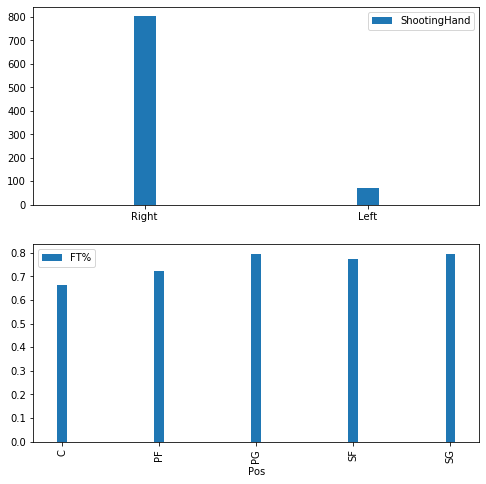

In [15]:
plot_general_info(database)
plot_score_percentage_per_position(database)
plot_throws_statistics(database)

##### Distributions:

In [ ]:
plot_distributions(database)
plot_distributions_of_shooting_percentage_only(database)

##### Variables Correlation:

In [ ]:
find_correlations(database)

 ### Fitting a model
 
 We will choose the relevant columns (ommiting most of the categorical variables) from our model_database

## Done pre-processing the data for now.
### Starting to prepare data for models

#### Choosing our model's parameters from dataset

In [ ]:
# we choose the relevant variables for our model:
continuous_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'draftRank','abs_min', 'Difference']
binary_parameters = ['playoffs', 'Pos', 'ShootingHand','First_shot',
                        'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in'] 
binary_database = pd.DataFrame(database[binary_parameters])
database[continuous_parameters].describe()

For our model, we assume that our variables are normally distributed.
We will examine this hypothesis and normalize the variables

We'll plot the distribution plot of the variables 'FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference'
(in 3 different plots because of the scale diffrence) :

### Splitting dataset to test-train to avoid data-leak

In [7]:
## SPLITTING DATASET TO TRAIN AND TEST

v = database.player.value_counts()
database = database[database.player.isin(v.index[v.gt(200)])] ## leave only players with more than 200 games.

model_parameters = ['player','playoffs', 'Pos', 'ShootingHand', 'FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight',
                    'draftRank','abs_min', 'Difference','shot_made','First_shot',
                    'Second_shot','Third_shot','First_shot_was_in','Second_shot_was_in']
model_database = database[model_parameters]
model_database.describe()

# Keep small database with original FT%
db_for_baseline_model = model_database[["FT%","shot_made"]]


Y = model_database['shot_made']
X = model_database.drop(columns=['shot_made','player'])

X_raw_train, X_raw_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

train_counts = y_train.value_counts()
print(f"Shots made are {train_counts[1]/y_train.shape[0]:.2f} % of train dataset")
print(f"Shots missed are {train_counts[0]/y_train.shape[0]:.2f} % of train dataset")
print("--------------------------------------")
test_counts = y_test.value_counts()
print(f"Shots made are {test_counts[1]/y_test.shape[0]:.2f} % of test dataset")
print(f"Shots missed are {test_counts[0]/y_test.shape[0]:.2f} % of test dataset")

Shots made are 0.76 % of train dataset
Shots missed are 0.24 % of train dataset
--------------------------------------
Shots made are 0.76 % of test dataset
Shots missed are 0.24 % of test dataset


## Baseline Model
Predicit free-throw success only with FT% feature. No learning process or algorithm is used here.
Threshold classificator, FT% over 0.5 will be predicted as 1, else 0.

In [9]:
## Baseline model

baseline_predict = db_for_baseline_model["FT%"].apply(lambda x: 1 if x>=0.6 else 0)
expected = database.shot_made
print(metrics.classification_report(expected, baseline_predict))

              precision    recall  f1-score   support

           0       0.45      0.11      0.18    128797
           1       0.78      0.96      0.86    413322

    accuracy                           0.76    542119
   macro avg       0.61      0.53      0.52    542119
weighted avg       0.70      0.76      0.70    542119



## Logisitic Regression
- Positions are transformed to numerical
- semiNormal features standarted to mean=0, std=1
- nonNormal_parameters rescaled to 0-1 range

In [12]:
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()
X_train,X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
# Check model results with position as numeric values
X_train_pos_numeric = preProcess_position(X_train)
X_test_pos_numeric = preProcess_position(X_test)
print(logreg(X_train_pos_numeric.values, y_train.values,X_test_pos_numeric.values, y_test))
# Check model results with position as one-hot encoded
X_train_pos_one_hot,X_test_pos_one_hot = make_pos_column_as_one_hot(X_train,X_test)
print(logreg(X_train_pos_one_hot.values, y_train.values,X_test_pos_one_hot.values, y_test))


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.38      0.50      0.43    178900
weighted avg       0.58      0.76      0.66    178900

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.38      0.50      0.43    178900
weighted avg       0.58      0.76      0.66    178900



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Linear SVM Model
- Positions are transformed to numerical
- semiNormal features standarted to mean=0, std=1
- nonNormal_parameters rescaled to 0-1 range

In [13]:
# # Pre-process for this model
# mm = MinMaxScaler()
# sc = StandardScaler()
# semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
# nonNormal_parameters = ['abs_min', 'draftRank']

# X_train = X_raw_train.copy()
# X_test = X_raw_test.copy()

# X_train[semiNormal_parameters] = sc.fit_transform(X_train[semiNormal_parameters])
# X_test[semiNormal_parameters] = sc.fit_transform(X_test[semiNormal_parameters])
# X_train[nonNormal_parameters] = mm.fit_transform(X_train[nonNormal_parameters])
# X_test[nonNormal_parameters] = mm.fit_transform(X_test[nonNormal_parameters])

# # changing the position variable from categorial variable to numeric variable:
# from preProcess import preProcess_position
# X_train = preProcess_position(X_train)
# X_test = preProcess_position(X_test)
# ## End pre-process


# # Linear SVM Model
# from sklearn.svm import SVC
# linear_svm_model = SVC(kernel='linear', class_weight='balanced',verbose=True,C=1)
# linear_svm_model.fit(X_train.values, y_train.values)
# print("Training DONE!")
# predictions = linear_svm_model.predict(X_test.values)
# print(metrics.classification_report(y_test, predictions))

### Neural Net - binary_crossentropy LOSS
- Position feature one-hod encoded
- All features standarted to mean=0, std=1


In [16]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']
X_train = X_raw_train.copy()
X_test = X_raw_test.copy()
X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)
## End pre-process

print("Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run")
text = input()
if text.lower() == "skip":
    # load json and create model
    json_file = open('saved_models/neural_net_binary_crossentropy_loss.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("saved_models/neural_net_binary_crossentropy_loss.h5")
    print("Loaded model from disk")
else:
    model = neural_net_model(X_train,y_train)
    history = model.fit(X_train, y_train, epochs=100, batch_size=256)
    
print("Metrics summary for training")
print(metrics.classification_report(y_model_train, np.round(model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run
skip
Loaded model from disk
Metrics summary for training


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     68063
           1       0.77      1.00      0.87    225646

    accuracy                           0.77    293709
   macro avg       0.38      0.50      0.43    293709
weighted avg       0.59      0.77      0.67    293709

Metrics summary for test
              precision    recall  f1-score   support

           0       0.62      0.00      0.00     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.69      0.50      0.43    178900
weighted avg       0.73      0.76      0.66    178900



#### We can see that because our dataset is not balanced, our models tend to predict '1' (shot made) most of the time, we have a problem. 
#### If we look at the recall parameter on label '0' (shot missed) we can see that we receive really bad perfomance on this metric.
#### We will try to attack this problem with some different methods.

## OverSampling try

One common way to tackle the issue of imbalanced data is over-sampling. Over-sampling refers to various methods that aim to increase the number of instances from the underrepresented class in the data set. In our case, these techniques will increase the number of fraudulent transactions in our data to 50:50 (instead of 25:75).

The easiest way to do so is to randomly select observations from the minority class and add them to the data set until we achieve a balance between the majority and minority class.

In [19]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_model_train)

print("Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run")
text = input()
if text.lower() == "skip":
    # load json and create model
    json_file = open('saved_models/neural_net_over_sampled_binary_cross_entropy.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights("saved_models/neural_net_over_sampled_binary_cross_entropy.h5")
    print("Loaded model from disk")
else:
    model = neural_net_model(X_train,y_train)
    history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=256)
print("Metrics summary for training")
print(metrics.classification_report(y_train_resampled, np.round(model.predict(X_train_resampled))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run
skip
Loaded model from disk
Metrics summary for training
              precision    recall  f1-score   support

           0       0.59      0.56      0.57    225646
           1       0.58      0.61      0.59    225646

    accuracy                           0.58    451292
   macro avg       0.58      0.58      0.58    451292
weighted avg       0.58      0.58      0.58    451292

Metrics summary for test
              precision    recall  f1-score   support

           0       0.31      0.57      0.41     42604
           1       0.82      0.61      0.70    136296

    accuracy                           0.60    178900
   macro avg       0.57      0.59      0.55    178900
weighted avg       0.70      0.60      0.63    178900



##### We can see that this method helps us to achieve better recall metric on label '0', but we receive a -10% perfomance on accuracy.

## FocalLOSS try

focal loss down-weights the well-classified examples. This has the net effect of putting more training emphasis on that data that is hard to classify. In a practical setting where we have a data imbalance, our majority class will quickly become well-classified since we have much more data for it. Thus, in order to insure that we also achieve high accuracy on our minority class, we can use the focal loss to give those minority class examples more relative weight during training.
Paper: https://arxiv.org/abs/1708.02002

![title](img/focal_loss.png)

In [20]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


print("Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run")
text = input()
if text.lower() == "skip":
    # load json and create model
    json_file = open('saved_models/neural_net_focal_loss.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    focal_loss_model = model_from_json(loaded_model_json)
    # load weights into new model
    focal_loss_model.load_weights("saved_models/neural_net_focal_loss.h5")
    print("Loaded model from disk")
else:
    focal_loss_model = focal_loss_nn_model(X_train,y_model_train,focal_loss)
    history = focal_loss_model.fit(X_train, y_model_train, epochs=200, batch_size=256)
    
print("Metrics summary for training")
print(metrics.classification_report(y_model_train, np.round(focal_loss_model.predict(X_train))))

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(focal_loss_model.predict(X_test))))

Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run
skip
Loaded model from disk
Metrics summary for training
              precision    recall  f1-score   support

           0       0.30      0.56      0.39     68063
           1       0.82      0.61      0.70    225646

    accuracy                           0.60    293709
   macro avg       0.56      0.58      0.55    293709
weighted avg       0.70      0.60      0.63    293709

Metrics summary for test
              precision    recall  f1-score   support

           0       0.31      0.57      0.41     42604
           1       0.82      0.61      0.70    136296

    accuracy                           0.60    178900
   macro avg       0.57      0.59      0.55    178900
weighted avg       0.70      0.60      0.63    178900



In [32]:
model_json = focal_loss_model.to_json()
# with open("saved_models/neural_net_focal_loss.json", "w") as json_file:
#     json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("saved_models/neural_net_focal_loss.h5")
print("Saved model to disk")

Saved model to disk


#### Also in this case, we get an improvement on our label '0' recall , but our accuracy performance is still lower comparing to the baseline model
#### Comparing against the model trained with overSampling we receive a lower perfomance on '0' recall metric, but a better accuracy.

### xgboost regressor model with Shap visualizations

Series.base is deprecated and will be removed in a future version


[18:16:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.38      0.50      0.43    178900
weighted avg       0.58      0.76      0.66    178900



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


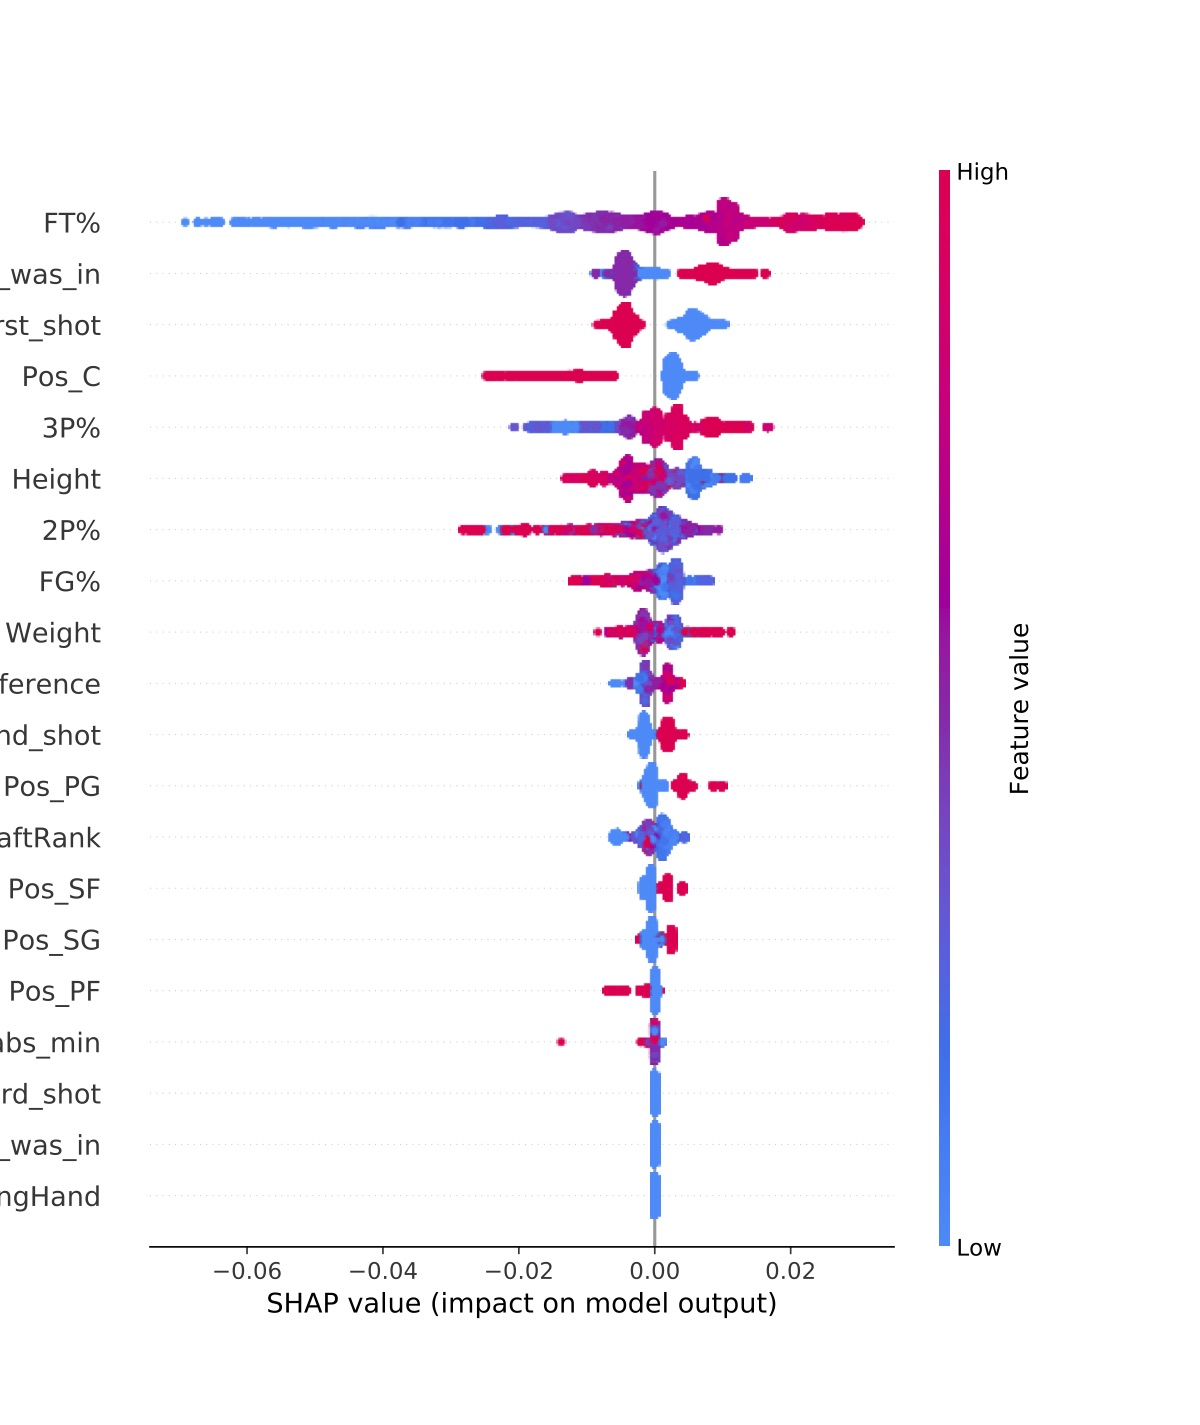

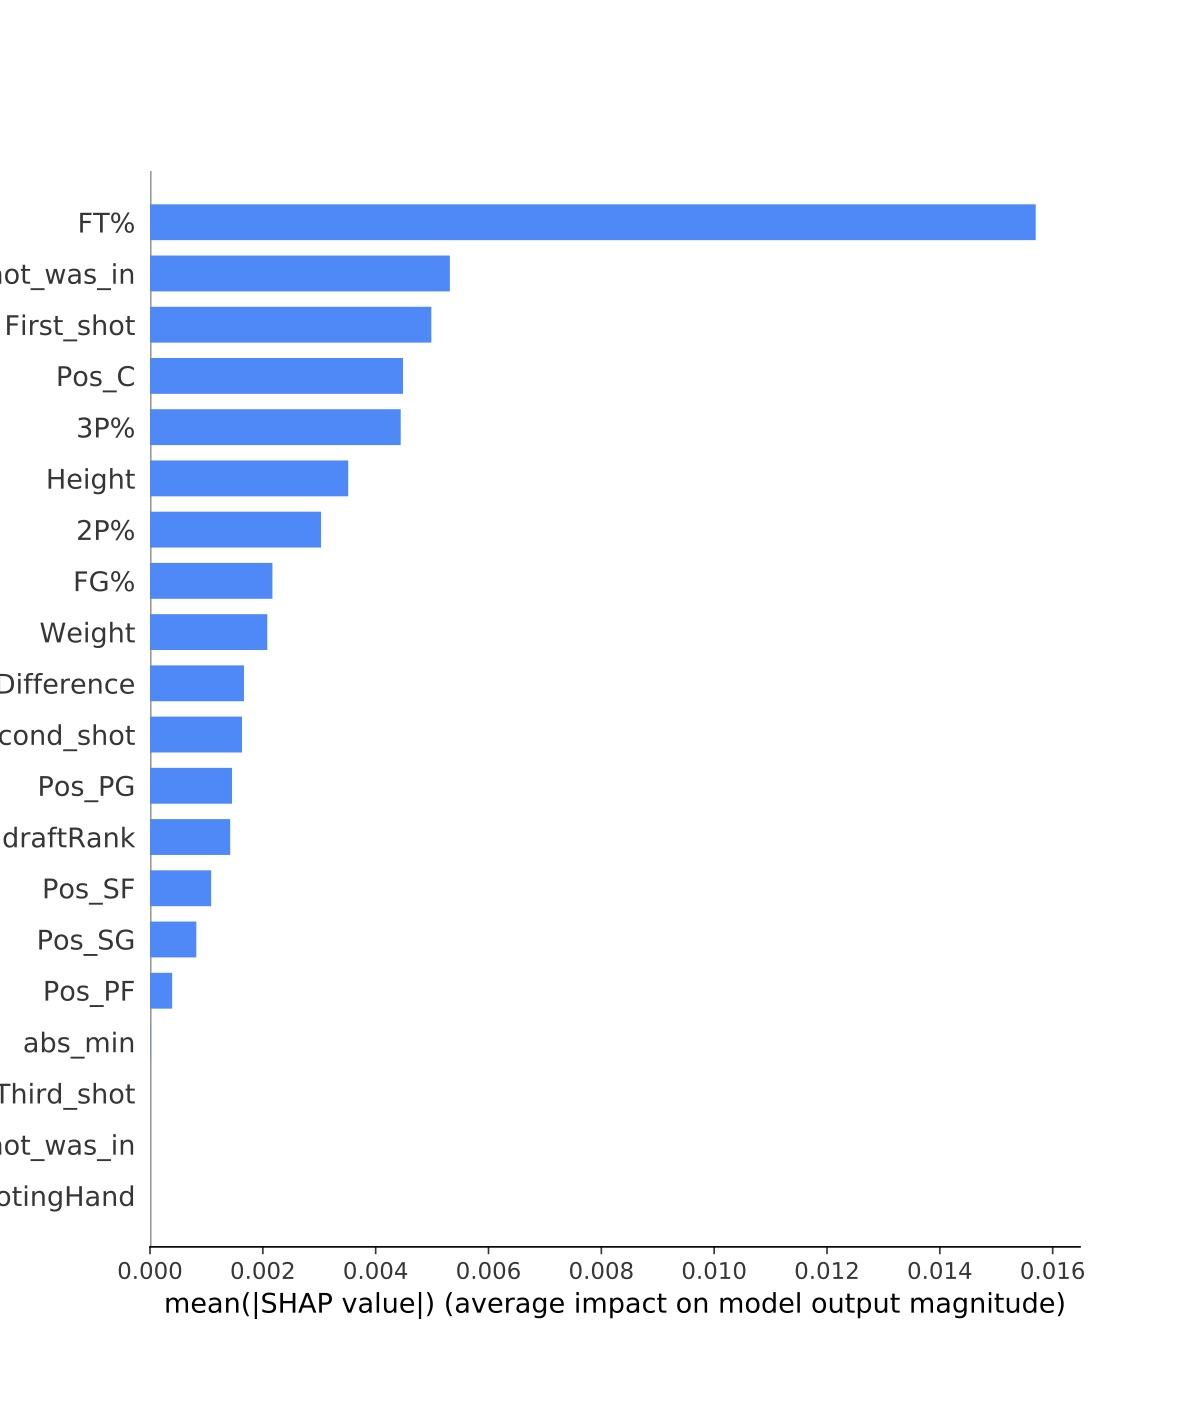

In [50]:
# Pre-process for this model

semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

model = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 10)
model.fit(X_train,y_model_train)

print(metrics.classification_report(y_test, np.round(model.predict(X_test))))

# Code that create SHAP visualizations, commented, it takes time, visualizations are loaded.
# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train,show=False)
# shap.summary_plot(shap_values, X_train, plot_type="bar")


display(Image("shap_plots/xgboost_regressor_summary_plot.jpg", width=600, height=300))
display(Image("shap_plots/xgboost_regressor_summary_plot_bar.jpg", width=600, height=300))

##### So we understand now, our imbalanced dataset is a problem, and our tries to fix this unbalance results as lower accuracy performance.
##### We will try to train different models to understand which features are the dominant in the models

### Xgboost classifier model with Shap visualizations

Metrics summary for test
              precision    recall  f1-score   support

           0       0.59      0.00      0.01     42604
           1       0.76      1.00      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.68      0.50      0.44    178900
weighted avg       0.72      0.76      0.66    178900



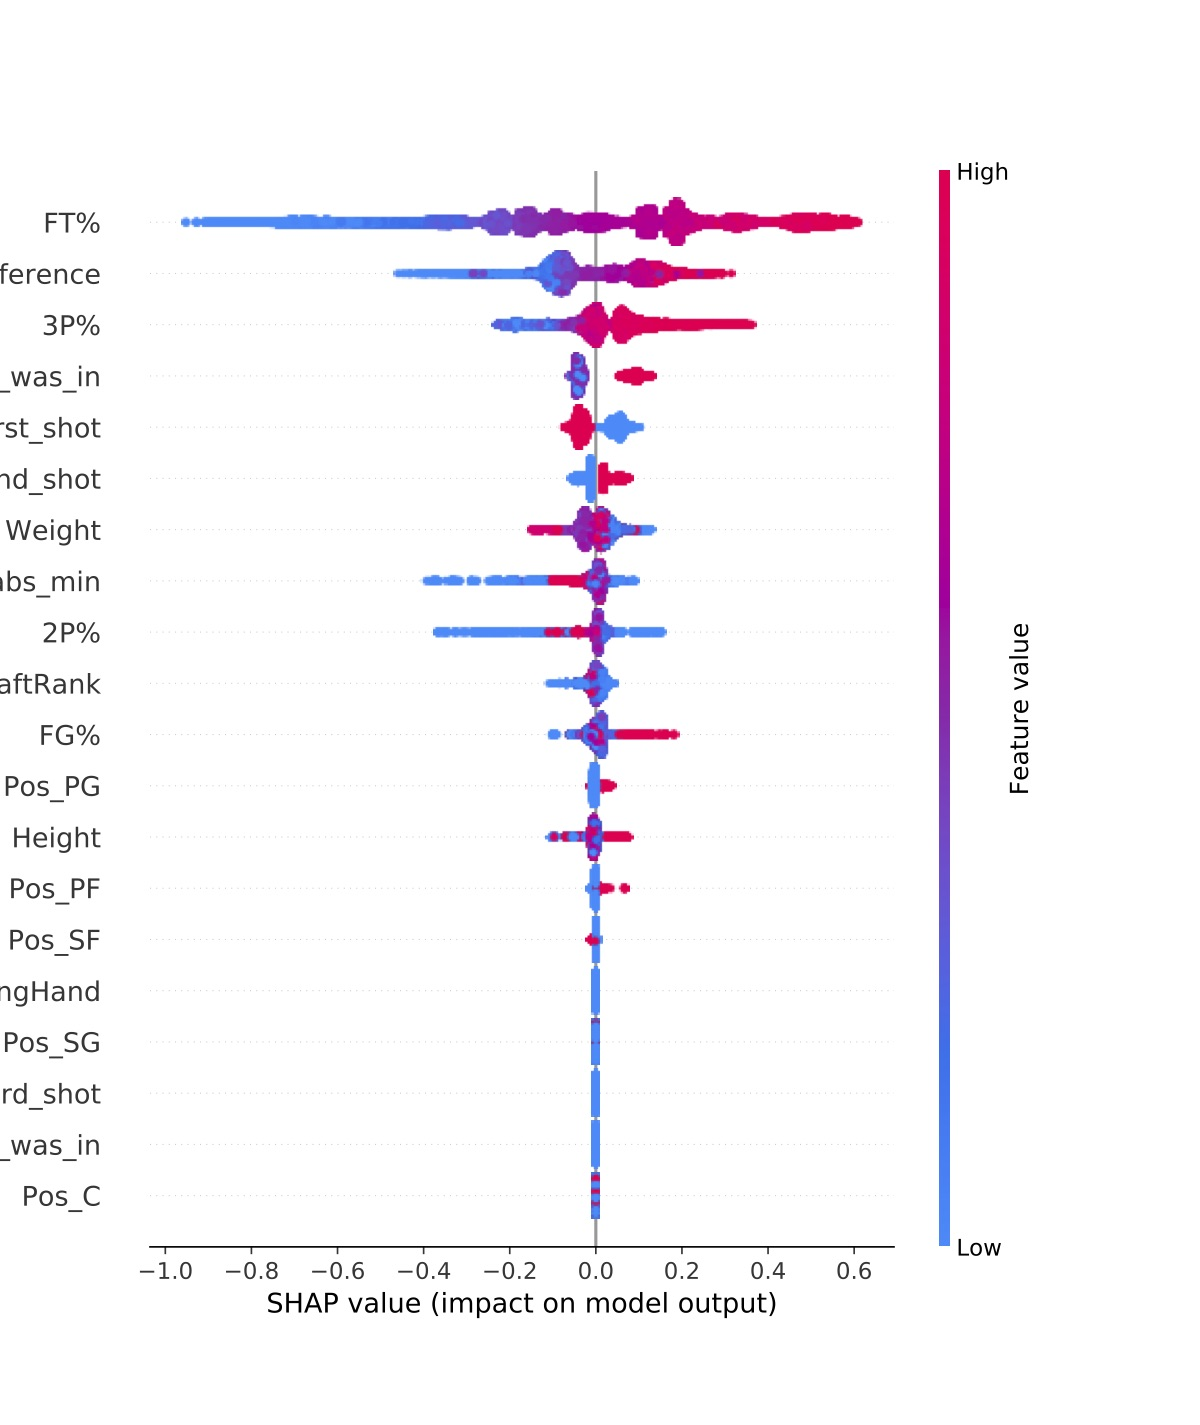

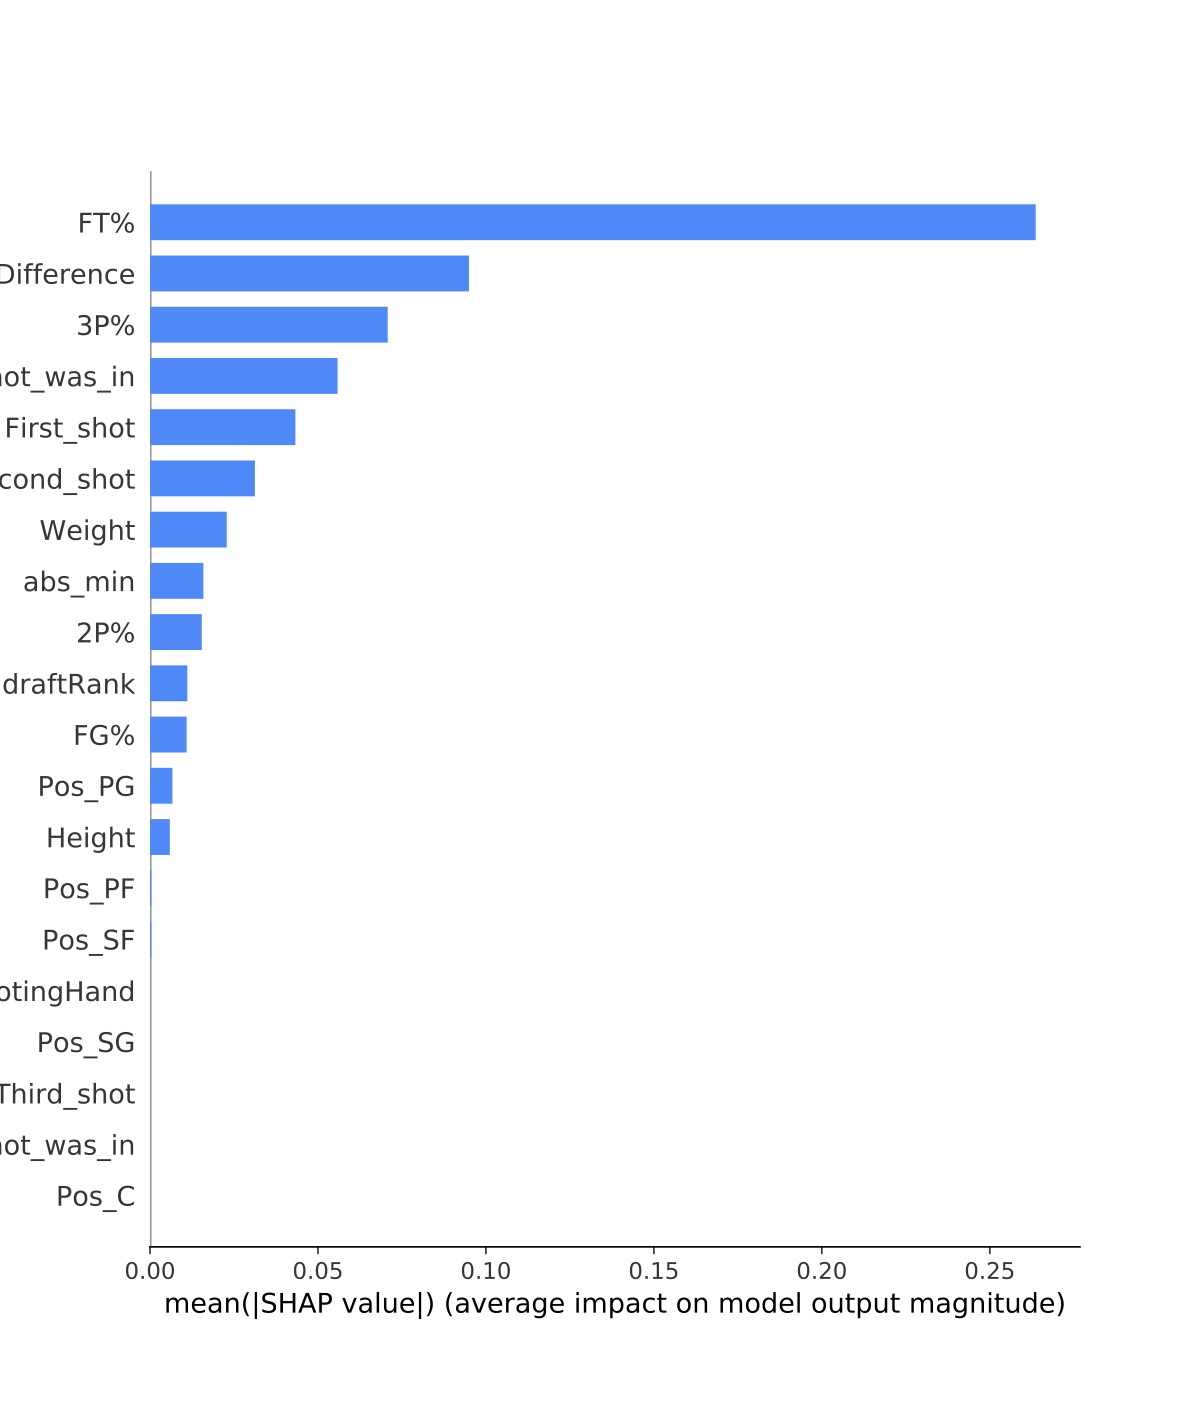

In [51]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

model = XGBClassifier()
 
# fit the model with the training data
model.fit(X_train,y_model_train)

print("Metrics summary for test")
print(metrics.classification_report(y_test, np.round(model.predict(X_test))))
# Code that create SHAP visualizations, commented, it takes time, visualizations are loaded.

# shap.initjs()
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar")


display(Image("shap_plots/xgboost_classifier_summary_plot.jpg", width=600, height=300))
display(Image("shap_plots/xgboost_classifier_summary_plot_bar.jpg", width=600, height=300))

#### Xgboost classifier model with FocalLoss


In [52]:

# Pre-process for this model

semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)


## End pre-process

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}


xgboster_focal = imb_xgb(special_objective='focal')
CV_focal_booster = GridSearchCV(xgboster_focal, {"focal_gamma":[2.0]})
CV_focal_booster.fit(X_train.values, y_model_train.values)
opt_focal_booster = CV_focal_booster.best_estimator_

print(metrics.classification_report(y_test, opt_focal_booster.predict_determine(X_test.values)))


              precision    recall  f1-score   support

           0       0.51      0.03      0.05     42604
           1       0.77      0.99      0.86    136296

    accuracy                           0.76    178900
   macro avg       0.64      0.51      0.46    178900
weighted avg       0.70      0.76      0.67    178900



## Random Forest

In [1]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']
X_train = X_raw_train.copy()
X_test = X_raw_test.copy()
X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)
## End pre-process

report, random_forest_model = random_forest(X_train.values, y_model_train.values,X_test.values, y_test,threshold_flag=False)

SyntaxError: invalid syntax (<ipython-input-1-9475959fff63>, line 11)

#### K-Nearset Neighbours
We searched for an optimal K at the range 1-11.
Performance of each model has been saved, (training & prediction takes time during this grid search) in order to load their quickly and avoid long runtime.

In [20]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)
## End pre-process

## Long RUNTIME code, is a grid seach in range 1-11 for the K-parameter in K-NN method.
## Results have been saved and loaded in next block

# training_reports , test_reports = knn_grid_search(X_train,y_model_train,X_test,y_test)
# for i in range(len(training_reports)):
#     print(f"results for KNN with {i} neighbors")
#     print("Metrics summary for training")
#     print(training_reports[i])
#     print("Metrics summary for test")
#     print(test_reports[i])


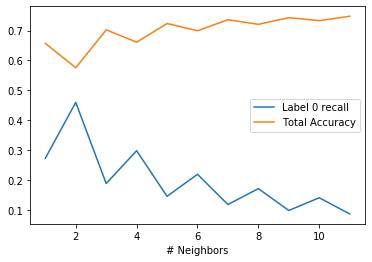

,Label 0 recall,Total Accuracy
# Neighbors,,
1,0.273519,0.656819
2,0.460004,0.575797
3,0.189372,0.702135
4,0.298798,0.661034
5,0.146700,0.723281
6,0.220261,0.699240
7,0.119285,0.736020
8,0.172331,0.720531
9,0.099427,0.742935


In [35]:
## Load saved results.
import matplotlib.pyplot as plt
import pandas as pd
import json
json_file = open('knn_results/test_reports_knn_reports')
test_reports = json.load(json_file)

label_0_recall = []
accuracy = []
for report in test_reports:
    label_0_recall.append(report['0']['recall'])
    accuracy.append(report['accuracy'])

neighbors = list(range(1,12))
plt.plot(neighbors,label_0_recall)
plt.plot(neighbors,accuracy)
plt.legend(['Label 0 recall', 'Total Accuracy'], loc='right')
plt.xlabel("# Neighbors")
plt.show()
d1 = {'Label 0 recall': label_0_recall, 'Total Accuracy': accuracy}
df = pd.DataFrame(data=d1)
df.index = pd.Index(range(1,12))
df.index.name = '# Neighbors'
df

In [ ]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(xgboost_dataset.iloc[:,0:10], figsize=(15,11))

### More Feature Engineering!
We process our dataset and checked if there is any correlation between if the player his made shot, what are the probability that he will made his second free throw.

In [23]:
a = database.groupby(["shot_made","First_shot_was_in"])
seconds_shots_number = database['Second_shot'].value_counts().tolist()[1]
for name, group in a:
    if name[0]==0 and name[1]== -1 :
        missed_curr_ft_and_missed_before = group.shape[0] / seconds_shots_number
    if name[0]==1 and name[1]== -1 :
        scored_curr_ft_and_missed_before = group.shape[0] / seconds_shots_number  
    if name[0]==0 and name[1]== 1 :
        missed_curr_ft_and_scored_before = group.shape[0] / seconds_shots_number
    if name[0]==1 and name[1]== 1 :
        scored_curr_ft_and_scored_before = group.shape[0] / seconds_shots_number

print("The distribution is:")
print(f"Probability to miss a free throw after missing past shot {missed_curr_ft_and_missed_before*100:.2f}%")
print(f"Probability to score a free throw after missing past shot {scored_curr_ft_and_missed_before*100:.2f}%")
print(f"Probability to miss a free throw after scoring past shot {missed_curr_ft_and_scored_before*100:.2f}%")
print(f"Probability to score a free throw after scoring past shot {scored_curr_ft_and_scored_before*100:.2f}%")


The distribution is:
Probability to missed a free throw after missing past shot 6.87%
Probability to score a free throw after missing past shot 19.37%
Probability to missed a free throw after scoring past shot 14.97%
Probability to score a free throw after scoring past shot 60.58%


We can see that we expect maybe the feature that there is an higher probabilty to ***score a free throw after you alread score the one before*** will help us to improve our accuracy over this category, but we have to be honest and to say that we didn't see any significant improvement (The models showed over all this notebook where trained already with these features, we avoid to show extra results and plots to keep this notebook to a normal length)

## You have to convince me you are going to score!

After different types of tries, one of our tries is to classify to a 'made' label (label 1) not if the propability predict for this shot was higher than 0.5 (as all models did until now). Now we raise the bar, and ask for more confidence score (higher threshold) to classify a shot as made one.

Plotting random forest performance (recall at label 0 & accuracy) as function of threshold value

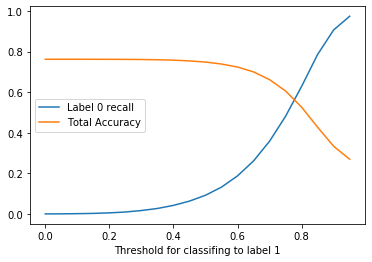

In [12]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']
X_train = X_raw_train.copy()
X_test = X_raw_test.copy()
X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)
## End pre-process

### Long code that has been comented, instead it has been dumped and loaded now to run faster.
# report, random_forest_model = random_forest(X_train.values, y_model_train.values,X_test.values, y_test,threshold_flag=False)
# print("Training is done")
# random_forest_recalls, random_forest_accuracies = plot_as_func_threshold(X_test.values,y_test,random_forest_model)
#np.asarray(recalls).dump("recalls_for_random_forest_thresholds.np")
#np.asarray(accuracy).dump("accuracies_for_random_forest_thresholds.np")

random_forest_recalls = np.load('recalls_for_random_forest_thresholds.np',allow_pickle=True)
random_forest_accuracies = np.load('accuracies_for_random_forest_thresholds.np',allow_pickle=True)
thresholds = np.arange(0.0,1,0.05)
plt.plot(thresholds,random_forest_recalls)
plt.plot(thresholds,random_forest_accuracies)
plt.legend(['Label 0 recall', 'Total Accuracy'], loc='center left')
plt.xlabel("Threshold for classifing to label 1")
plt.show()

Plotting Neural Net with Focal Loss performance (recall at label 0 & accuracy) as function of threshold value

Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run
skip
Loaded model from disk


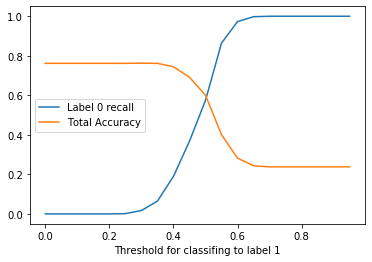

In [9]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']

X_train = X_raw_train.copy()
X_test = X_raw_test.copy()

X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)

## End pre-process


# Define our custom loss function
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.25
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))


print("Following block will run a training for a neural net it can take a while, you have a option to skip training, if you want to skip training please enter: skip, else train will run")
text = input()
if text.lower() == "skip":
    # load json and create model
    json_file = open('saved_models/neural_net_focal_loss.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    focal_loss_model = model_from_json(loaded_model_json)
    # load weights into new model
    focal_loss_model.load_weights("saved_models/neural_net_focal_loss.h5")
    print("Loaded model from disk")
else:
    focal_loss_model = focal_loss_nn_model(X_train,y_model_train,focal_loss)
    history = focal_loss_model.fit(X_train, y_model_train, epochs=200, batch_size=256)

### Long code that has been comented, instead it has been dumped and loaded now to run faster.
# focal_loss_nn_recalls, focal_loss_nn_accuracies = plot_as_func_threshold(X_test.values,y_test,focal_loss_model)
# np.asarray(recalls).dump("recalls_for_focal_loss_model_thresholds.np")
# np.asarray(accuracy).dump("accuracies_for_focal_loss_model_thresholds.np")
focal_loss_nn_recalls = np.load('recalls_for_focal_loss_model_thresholds.np',allow_pickle=True)
focal_loss_nn_accuracies = np.load('accuracies_for_focal_loss_model_thresholds.np',allow_pickle=True)
thresholds = np.arange(0.0,1,0.05)
plt.plot(thresholds,focal_loss_nn_recalls)
plt.plot(thresholds,focal_loss_nn_accuracies)
plt.legend(['Label 0 recall', 'Total Accuracy'], loc='center left')
plt.xlabel("Threshold for classifing to label 1")
plt.show()

We can notice here that this model sensitivity of this model for the threshold is more sharp, this can be explained as the activation of our cell in this neural network model is a 'sigmoid' as we can see the recall & accuracy looks like sigmoid (left side we classify as label 1 all the dataset and on the right side we classify almost all the dataset to label 0).
We prefer the behaivor of the random forest model, we can achieve a better improve over recall on label 0 metric without damaging so much the accuracy over all the dataset.

LinAlgError: singular matrix

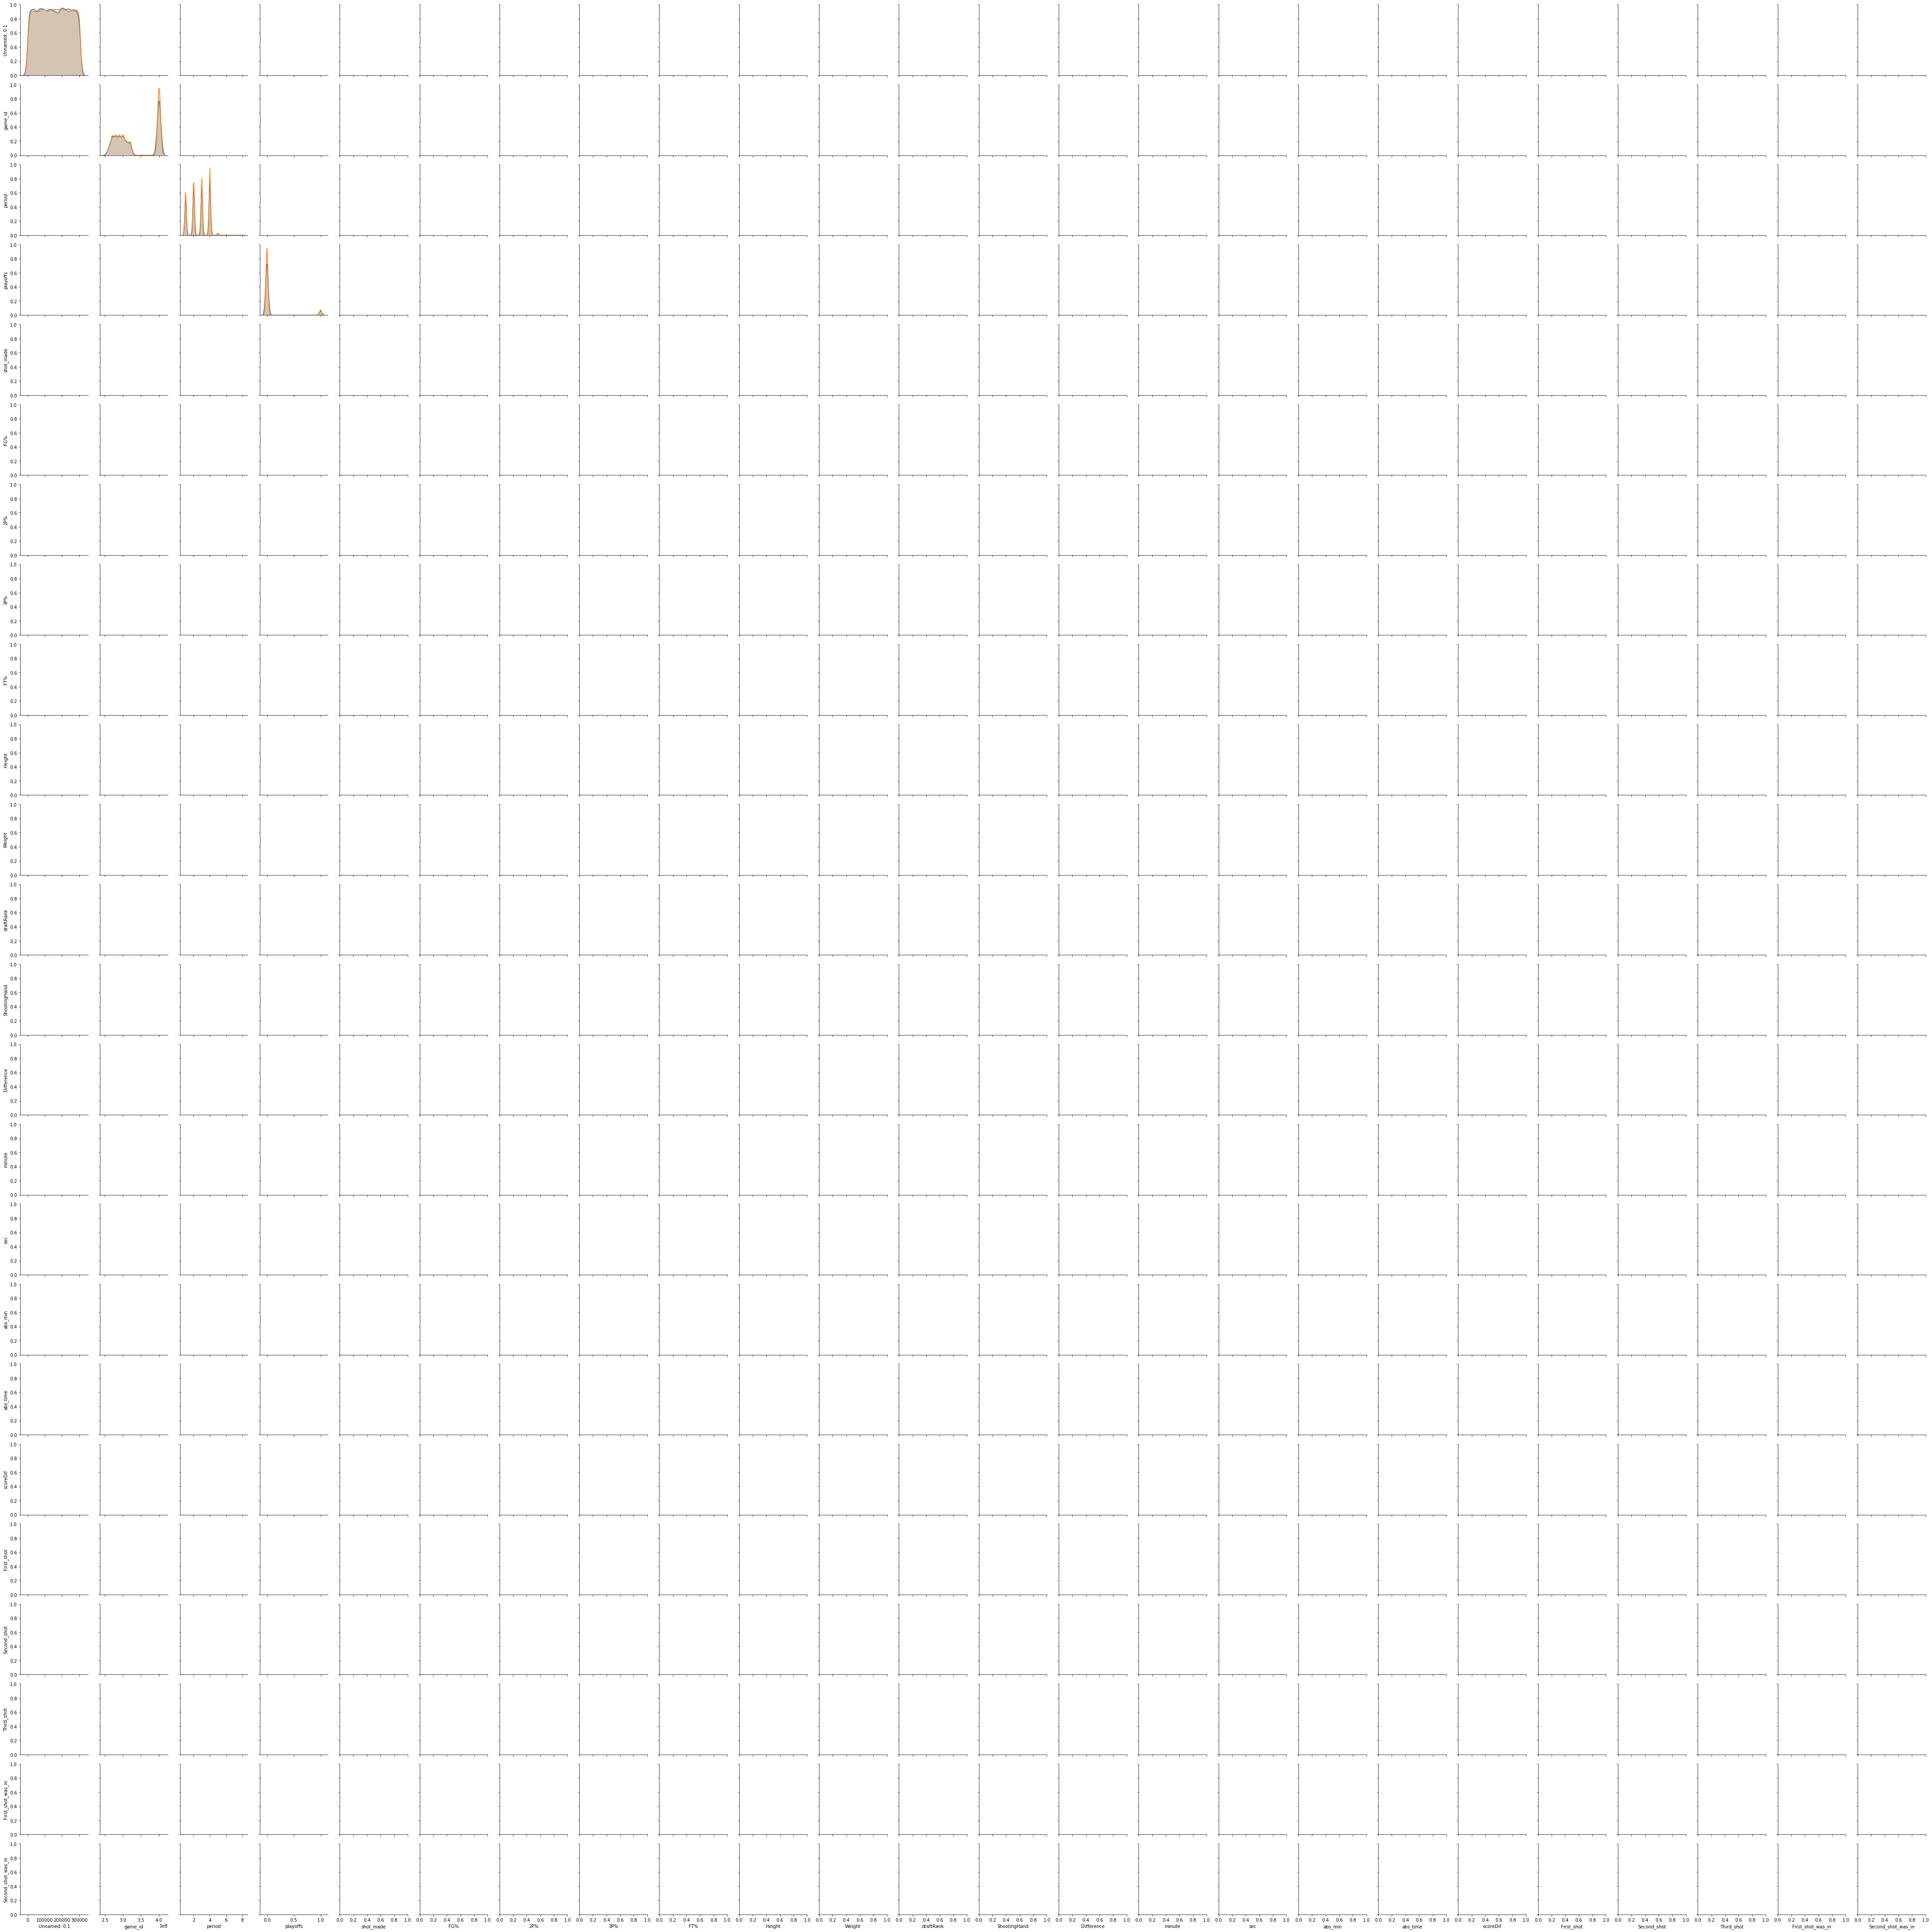

In [24]:
sns.pairplot(database, hue = 'shot_made')

In [8]:
database.tail(20)

,Unnamed: 0.1,end_result,game,game_id,period,play,player,playoffs,score,season,...,sec,abs_min,abs_time,scores,scoreDif,First_shot,Second_shot,Third_shot,First_shot_was_in,Second_shot_was_in
308871,308755,104 - 118,DAL - OKC,400874368,2,Dirk Nowitzki makes free throw 1 of 2,Dirk Nowitzki,1,56 - 61,2015 - 2016,...,20,23,1360,"['56 ', ' 61']",5,1,0,0,0,0
308872,308756,104 - 118,DAL - OKC,400874368,2,Dirk Nowitzki makes free throw 2 of 2,Dirk Nowitzki,1,57 - 61,2015 - 2016,...,20,23,1360,"['57 ', ' 61']",4,0,1,0,1,0
308873,308757,104 - 118,DAL - OKC,400874368,2,Zaza Pachulia makes free throw 1 of 2,Zaza Pachulia,1,60 - 68,2015 - 2016,...,3,24,1437,"['60 ', ' 68']",8,1,0,0,0,0
308874,308758,104 - 118,DAL - OKC,400874368,2,Zaza Pachulia makes free throw 2 of 2,Zaza Pachulia,1,61 - 68,2015 - 2016,...,3,24,1437,"['61 ', ' 68']",7,0,1,0,1,0
308875,308759,104 - 118,DAL - OKC,400874368,3,Wesley Matthews makes free throw 1 of 2,Wesley Matthews,1,72 - 80,2015 - 2016,...,56,30,1744,"['72 ', ' 80']",8,1,0,0,0,0
308876,308760,104 - 118,DAL - OKC,400874368,3,Wesley Matthews makes free throw 2 of 2,Wesley Matthews,1,73 - 80,2015 - 2016,...,56,30,1744,"['73 ', ' 80']",7,0,1,0,1,0
308877,308761,104 - 118,DAL - OKC,400874368,3,Enes Kanter makes free throw 1 of 1,Enes Kanter,1,77 - 87,2015 - 2016,...,43,33,1937,"['77 ', ' 87']",10,1,0,0,0,0
308878,308762,104 - 118,DAL - OKC,400874368,4,Nick Collison misses free throw 1 of 2,Nick Collison,1,85 - 93,2015 - 2016,...,11,37,2209,"['85 ', ' 93']",8,1,0,0,0,0
308879,308763,104 - 118,DAL - OKC,400874368,4,Nick Collison makes free throw 2 of 2,Nick Collison,1,85 - 94,2015 - 2016,...,11,37,2209,"['85 ', ' 94']",9,0,1,0,-1,0
308882,308766,104 - 118,DAL - OKC,400874368,4,Dwight Powell makes free throw 1 of 2,Dwight Powell,1,88 - 94,2015 - 2016,...,26,38,2254,"['88 ', ' 94']",6,1,0,0,0,0


Lets' find our best option (for random forest model) to achieve the best performance on recall metric while maintaining a decent accuracy score (over 70%).
We will explore the range between 0.6 to 1 with 0.01 step. (Next running code is commented because it takes while to complete, but necessary printing showing the results has been added)

In [8]:
# Pre-process for this model
semiNormal_parameters = ['FG%', '2P%', '3P%', 'FT%', 'Height', 'Weight', 'Difference']
nonNormal_parameters = ['abs_min', 'draftRank']
X_train = X_raw_train.copy()
X_test = X_raw_test.copy()
X_train, X_test = data_normalization(semiNormal_parameters, nonNormal_parameters,X_train,X_test)
X_train, X_test = make_pos_column_as_one_hot(X_train, X_test)
X_train, y_model_train = detect_and_remove_outliers(X_train, y_train)
## End pre-process

report, random_forest_model = random_forest(X_train.values, y_model_train.values,X_test.values, y_test,threshold_flag=True)
print(report)

Optimal threshold is: 0.64
              precision    recall  f1-score   support

           0       0.34      0.24      0.28     42604
           1       0.78      0.85      0.81    136296

    accuracy                           0.71    178900
   macro avg       0.56      0.55      0.55    178900
weighted avg       0.68      0.71      0.69    178900



              precision    recall  f1-score   support

           0       0.34      0.24      0.28     42604
           1       0.78      0.85      0.81    136296

    accuracy                           0.71    178900
   macro avg       0.56      0.55      0.55    178900
weighted avg       0.68      0.71      0.69    178900

